# Employee Churn - Random Forest

## Initialization

In [157]:
from pandas import Series, DataFrame
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [158]:
employee = pd.read_csv('employee_churn_data.csv')

## Encoding Categorical Variables

In [159]:
# categorical_columns = employee.select_dtypes(
#     include=['object', 'category']).columns

# # Function to label encode categorical columns based on value counts


# def label_encode_by_value_counts(df, columns):
#     for col in columns:
#         value_counts = df[col].value_counts()
#         label_encoder = LabelEncoder()
#         label_encoder.fit(value_counts.index)
#         df[col] = label_encoder.transform(df[col])


# # Label encode the categorical columns based on value counts
# label_encode_by_value_counts(employee, categorical_columns)

### Encode 'salary' feature

In [160]:
from sklearn.preprocessing import OrdinalEncoder

salary_mapping = {
    'low': 0,
    'medium': 1,
    'high': 2
}

# Apply ordinal encoding to the 'salary' column
employee['salary_encoded'] = employee['salary'].map(salary_mapping)
employee = employee.drop(columns='salary', axis=1)
employee.head()

,department,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month,left,salary_encoded
0,operations,0,0.577569,3,5.0,0.626759,0,180.866070,no,0
1,operations,0,0.751900,3,6.0,0.443679,0,182.708149,no,1
2,support,0,0.722548,3,6.0,0.446823,0,184.416084,no,1
3,logistics,0,0.675158,4,8.0,0.440139,0,188.707545,no,2
4,sales,0,0.676203,3,5.0,0.577607,1,179.821083,no,2


### Create dummy variables for 'department' feature

In [161]:
employee = pd.get_dummies(employee, columns=['department'], drop_first=True)
employee.head()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month,left,salary_encoded,department_admin,department_engineering,department_finance,department_logistics,department_marketing,department_operations,department_retail,department_sales,department_support
0,0,0.577569,3,5.0,0.626759,0,180.866070,no,0,0,0,0,0,0,1,0,0,0
1,0,0.751900,3,6.0,0.443679,0,182.708149,no,1,0,0,0,0,0,1,0,0,0
2,0,0.722548,3,6.0,0.446823,0,184.416084,no,1,0,0,0,0,0,0,0,0,1
3,0,0.675158,4,8.0,0.440139,0,188.707545,no,2,0,0,0,1,0,0,0,0,0
4,0,0.676203,3,5.0,0.577607,1,179.821083,no,2,0,0,0,0,0,0,0,1,0


### Encode 'left' (target) variable

In [162]:
left_mapping = {
    'no': 0,
    'yes': 1,
}

# Apply ordinal encoding to the 'left' column
employee['left_encoded'] = employee['left'].map(left_mapping)
employee = employee.drop(columns = 'left')
employee.head()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month,salary_encoded,department_admin,department_engineering,department_finance,department_logistics,department_marketing,department_operations,department_retail,department_sales,department_support,left_encoded
0,0,0.577569,3,5.0,0.626759,0,180.866070,0,0,0,0,0,0,1,0,0,0,0
1,0,0.751900,3,6.0,0.443679,0,182.708149,1,0,0,0,0,0,1,0,0,0,0
2,0,0.722548,3,6.0,0.446823,0,184.416084,1,0,0,0,0,0,0,0,0,1,0
3,0,0.675158,4,8.0,0.440139,0,188.707545,2,0,0,0,1,0,0,0,0,0,0
4,0,0.676203,3,5.0,0.577607,1,179.821083,2,0,0,0,0,0,0,0,1,0,0


### Scale Data?

## Splitting Data into Train and Test Sets

In [163]:
X = employee.drop('left_encoded', axis=1)
y = employee['left_encoded']

In [164]:
#split data into train and test (70/30)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=99)

## Random Forest Model Creation

### Training Model

In [170]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from itertools import product

# Define parameter combinations for each model
rf_num_estimators = [100, 250, 500, 750, 1000]  # Number of trees in the forest
rf_max_depth = [10, 15, 20, 30, 50]  # Maximum depth of the trees
rf_params = list(product(rf_num_estimators, rf_max_depth))


# Set random seed for reproducibility
np.random.seed(99)

# Initialize a list to store accuracy metrics
accuracies = []
precisions = []
recalls = []

# Perform k-fold cross-validation for parameter combinations
for params in rf_params:
    num_estimators, max_depth = params
    print("Testing parameter combination: num_estimators={}, max_depth={}".format(
        num_estimators, max_depth))

    # Create the Random Forest model
    model = RandomForestClassifier(n_estimators=num_estimators, max_depth=max_depth, random_state=1)

    # Perform k-fold cross-validation and get accuracy, precision, and recall scores
    cv_scores_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')
    cv_scores_recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')

    # Calculate mean scores for accuracy, precision, and recall
    accuracy = np.mean(cv_scores_accuracy)
    precision = np.mean(cv_scores_precision)
    recall = np.mean(cv_scores_recall)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    print("Cross-Validation Accuracy:", accuracy)
    print("Cross-Validation Precision:", precision)
    print("Cross-Validation Recall:", recall)
    print()
    
# Find the best hyperparameters based on the cross-validation performance
best_params_idx = np.argmax(accuracies)
best_params = rf_params[best_params_idx]
best_num_estimators, best_max_depth = best_params
print("Best hyperparameters: num_estimators={}, max_depth={}".format(
    best_num_estimators, best_max_depth))


Testing parameter combination: num_estimators=100, max_depth=10
Cross-Validation Accuracy: 0.858001397624039
Cross-Validation Precision: 0.8330576328184541
Cross-Validation Recall: 0.6499490213214122

Testing parameter combination: num_estimators=100, max_depth=15
Cross-Validation Accuracy: 0.8624737945492662
Cross-Validation Precision: 0.8214617967807648
Cross-Validation Recall: 0.6840162235443066

Testing parameter combination: num_estimators=100, max_depth=20
Cross-Validation Accuracy: 0.8634521313766597
Cross-Validation Precision: 0.8199992222289957
Cross-Validation Recall: 0.6892138079392289

Testing parameter combination: num_estimators=100, max_depth=30
Cross-Validation Accuracy: 0.8605171208944794
Cross-Validation Precision: 0.8121017578040158
Cross-Validation Recall: 0.6873169529315541

Testing parameter combination: num_estimators=100, max_depth=50
Cross-Validation Accuracy: 0.8613556953179595
Cross-Validation Precision: 0.8144755940262337
Cross-Validation Recall: 0.687789766

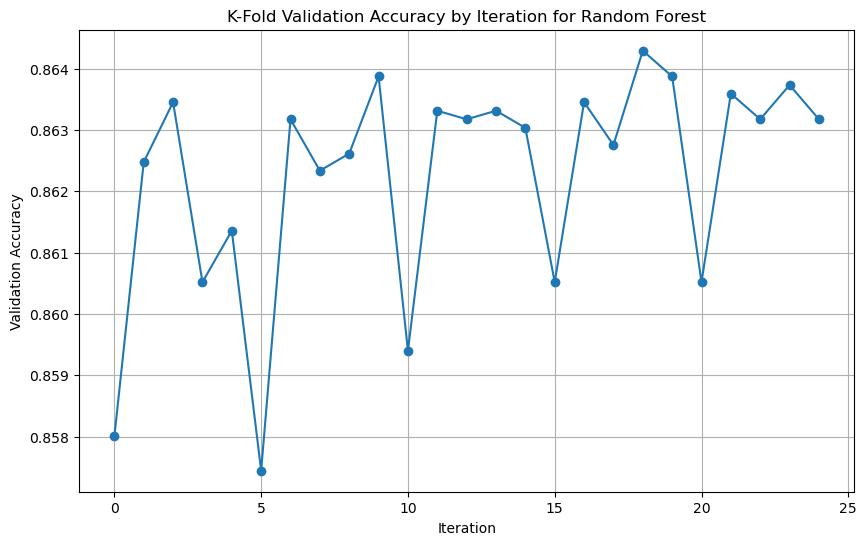

In [184]:
# Generate line graph of all iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies)), accuracies, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.title('K-Fold Validation Accuracy by Iteration for Random Forest')
plt.grid()
plt.show()

### Fitting Final Model

In [171]:
# Train the final model using the best hyperparameters on the full training set
final_model = RandomForestClassifier(n_estimators=best_num_estimators, max_depth=best_max_depth, random_state=99)
final_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=750, random_state=99)

### Test Accuracy

In [175]:
# Make probability predictions on the testing set using the best model
y_test_prob = final_model.predict_proba(X_test)

# Set threshold at 0.5 and convert probabilities to binary predictions
threshold = 0.5
y_test_pred = (y_test_prob[:, 1] > threshold).astype(int)

# Calculate accuracy, precision, and recall on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("Testing Accuracy:", test_accuracy)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)

Testing Accuracy: 0.8758909853249476
Testing Precision: 0.8085808580858086
Testing Recall: 0.7313432835820896


## Confusion Matrix

Confusion Matrix:


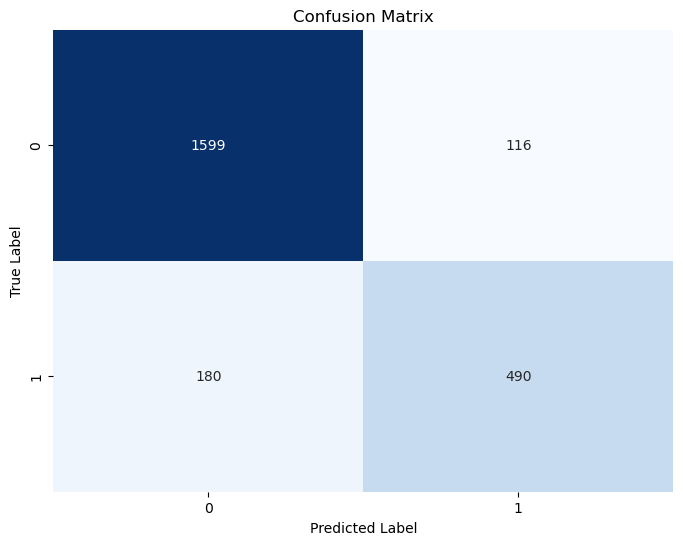

In [176]:
from sklearn.metrics import confusion_matrix

# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Feature Importance

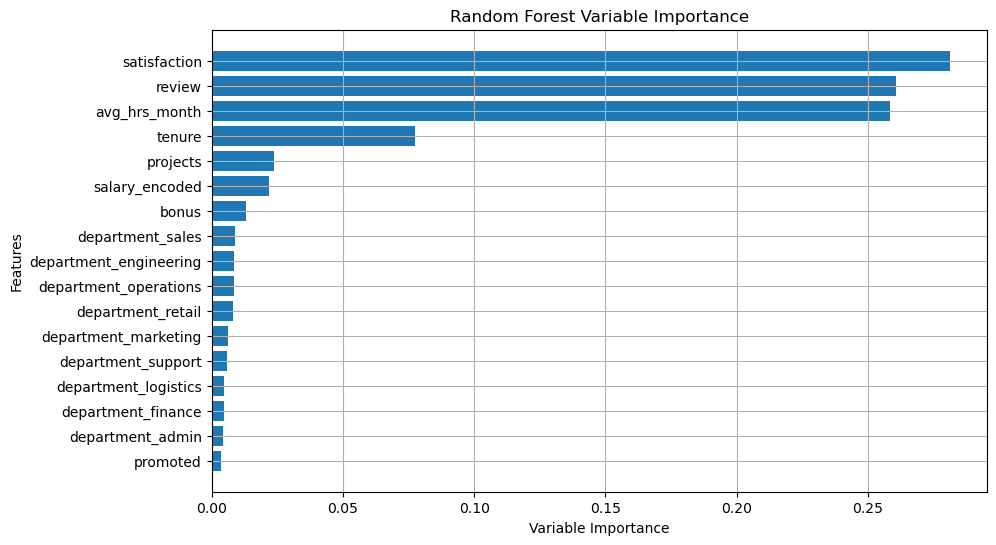

In [179]:
# Get variable importance from the best model
variable_importance = final_model.feature_importances_

# Plot the variable importances as a bar chart
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(variable_importance)
plt.barh(range(len(variable_importance)),
         variable_importance[sorted_idx], align='center')
plt.yticks(range(len(variable_importance)),
           np.array(X_train.columns)[sorted_idx])
plt.xlabel('Variable Importance')
plt.ylabel('Features')
plt.title('Random Forest Variable Importance')
plt.grid()
plt.show()